## 1. 인물 모드 문제점 찾기

In [1]:
!pip install opencv-python pixellib

### Step 1. 인물모드 직접 해 보기

In [2]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt
import os

print(cv2.__version__)

4.11.0


원본 고양이 이미지 크기: (1024, 768, 3)
배경(사막) 이미지 크기: (1024, 1536, 3)


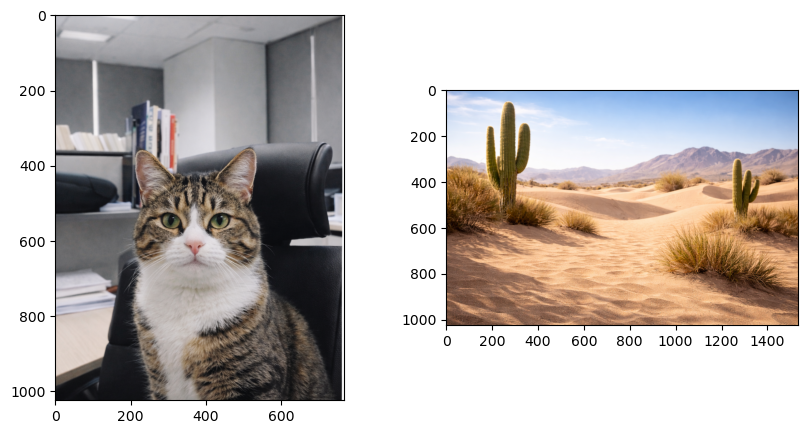

In [3]:
home_dir = os.getenv('HOME')
cat_img_path = os.path.join(home_dir, "work/AIFFEL_quest_eng/Computer_Vision/CV02/cat.jpg")  # 고양이 이미지를 준비해주세요
sand_img_path = os.path.join(home_dir, "work/AIFFEL_quest_eng/Computer_Vision/CV02/sand.jpg")  # 사막 배경 이미지를 준비해주세요

cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

In [4]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(cat_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


추론 마스크 크기 (Before Resize): (520, 520)


In [5]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (1024, 768)


In [6]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [0 8]


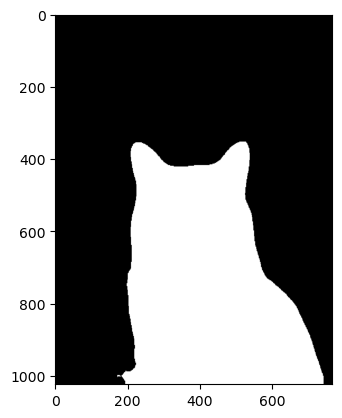

In [7]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

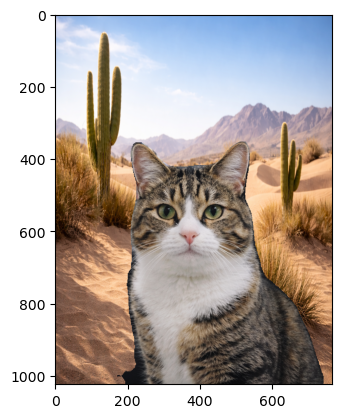

In [10]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 고양이 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.savefig('result_cat.png')
plt.show()

### Step 2. 사진에서 문제점 찾기

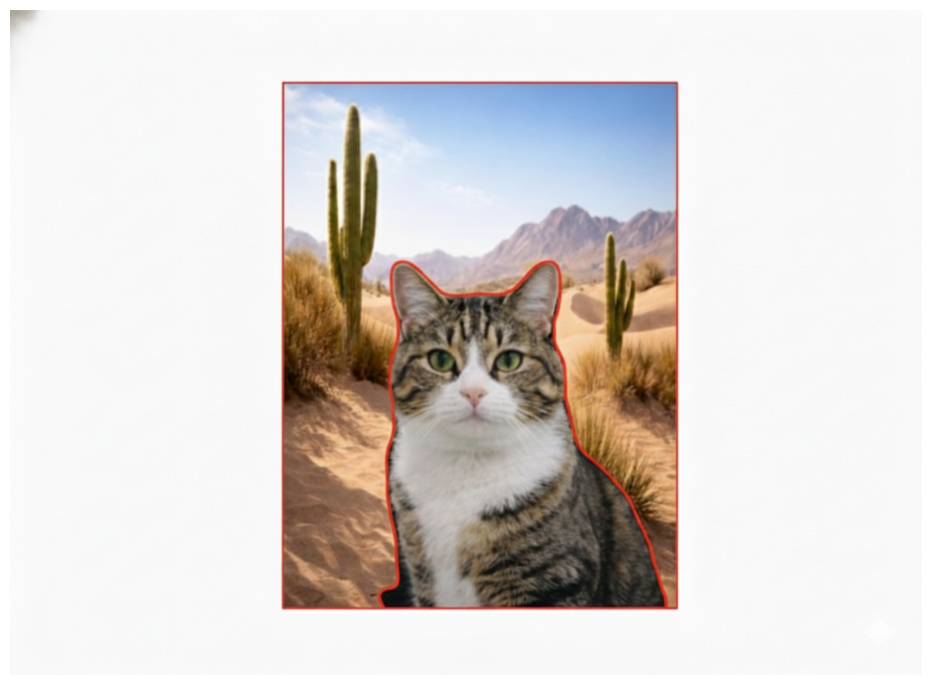

In [22]:
from PIL import Image

eval_result_path = os.path.join(home_dir, "work/AIFFEL_quest_eng/Computer_Vision/CV02/eval_result_cat.png")  # 고양이 이미지를 준비해주세요
eval_result_img = Image.open(eval_result_path)
width, height = eval_result_img.size

# 2. DPI(Dots Per Inch) 설정 
my_dpi = 100

# 3. Figure 크기 설정 (인치 단위 = 픽셀 / DPI)
plt.figure(figsize=(width/my_dpi, height/my_dpi), dpi=my_dpi)

plt.imshow(eval_result_img)
plt.axis('off') # 축 정보 숨기기 (선택사항)
plt.show()


1. 고양이 외곽선, 전체 실선 <br />
고양이의 형태를 따라 지나치게 매끄럽거나 딱딱하게 따진 경계면.
 - DeepLabV3+ 모델은 픽셀 단위로 객체를 분류하지만, 고양이의 털이나 수염 같은 미세한 디테일을 보존하는 데는 한계점 존재.
   이로 인해 외곽선이 부드러운 털 느낌이 아니라 마치 가위로 오려낸 듯한 계단 현상과 이질감이 발생함.

2. 하단부 검은색 영역, 하단 실선 및 점선 <br />
고양이 아랫부분이 뭉개지거나 검게 타버린 듯한 현상.
 - 데이터 부족: 학습 데이터셋에서 고양이의 하단(발 부분)이 지면과 맞닿아 가려진 경우가 많으면,
   모델이 이 경계를 정확히 추론하지 못하고 배경과 객체를 혼동하여 마스크를 비정상적으로 생성.
 - 주변 사물 또는 그림자 오인: 원본 이미지의 주변 사물 또는 그림자 영역을 고양이의 일부로 잘못 인식하여 검은색 노이즈가 합성 결과물에 포함.

3. 사막 지면과의 접점, 하단 점선 <br />
지면과 맞닿는 부분의 원근감 및 그림자 부재.
 - 단순 합성은 두 이미지의 픽셀을 얹는 작업일 뿐, 광원에 의한 물리적 상호작용을 계산하지 않기 때문에
   고양이 무게에 의해 눌린 모래의 질감이나 바닥으로 드리워지는 그림자가 생성되지 않아 공중에 떠 있는 듯한 느낌을 줌.

### Step 3. 해결 방법을 제안해 보기

1. 경계면 계단 현상 및 후광 효과 개선
 - 가우시안 블러(Gaussian Blur) 마스크 적용: 세그멘테이션 마스크의 경계면에 아주 미세한 블러를 적용한 후 합성할 경우,
   경계가 부드러워지면서 배경과 자연스럽게 섞이며, 이질감 감소.
 - 이미지 매팅(Image Matting) 도입: 수염이나 털 같은 세밀한 투명도가 필요한 부분은 단순 분류 대신
   Deep Image Matting이나 IndexNet 같은 매팅 전용 모델을 사용하여 알파 채널(Alpha Channel)을 정교하게 추출해야 함.
 - Guided Filter 사용: 원본 이미지의 가이드 정보를 바탕으로 마스크의 경계선을 정밀하게 다듬어주는 필터링 기법을 적용하면
   픽셀 깨짐을 줄일 수 있음.

2. 하단부 검은 노이즈 및 왜곡 해결
 - CRF(Conditional Random Fields) 후처리: 모델 출력 직후에 CRF를 적용하면
   픽셀 간의 상관관계를 계산해 뜬금없는 검은색 노이즈(오분류 픽셀)를 주변 색상이나 배경으로 보정해 줌.
 - 마스크 침식/팽창(Erosion/Dilation): OpenCV의 형태학적 연산을 통해
   외곽의 불필요한 테두리를 1~2픽셀 깎아내면(Erosion), 배경의 잔상이 남는 현상을 방지 가능.

3. 물리적 이질감(그림자 및 접점) 해결
 - 그림자 생성 아키텍처: 합성 후 고양이 하단부 마스크를 기반으로 반투명한 검은색 타원을 만들고,
   가우시안 블러와 왜곡(Skew)을 주어 지면에 투영된 그림자를 인위적으로 추가.
 - 포아송 이미지 블렌딩(Poisson Image Blending): 배경 사막과 고양이 사이의 경계 영역에서
   색상 기울기(Gradient)를 부드럽게 일치시켜주는 수학적 기법으로, 이를 통해 광원이 다른 두 이미지의 이질감을 크게 감소 가능.

4. 색감 및 광원 일치 (Relighting)
 - 히스토그램 매칭(Histogram Matching): 고양이 이미지의 색감 분포를 사막 배경의 색감(따뜻한 톤)에 맞게 강제로 변환하여
   전체적인 톤앤매너를 통일.
 - 글로벌 조명 보정: 사막의 광원 방향(좌측 상단)에 맞춰 고양이의 오른쪽 면을 살짝 어둡게 처리하는 마스킹 작업을 추가하면 입체감이 살아남.
